In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.layers import Bidirectional
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, SGD
import os
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# can check if you are using your GPU. 
# macOS users -> this will not work, you need to go through a great deal of pain to get it working

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU yes")
else:
    print("No GPU")

GPU yes


In [3]:
import matplotlib.pyplot as plt

In [4]:
big = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/train_set_1/big_data.csv')
# test_set = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/test_set/processed_data.csv')

Columns (18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
# due (i suppose) to the large size of the file, there was an issue with some dummy variables, we can fix it easily

nl_df = big.copy(deep = True) # do this otherwise we have very annoying issue

nl_df['time'] = pd.to_datetime(nl_df['time'])
affected_month_columns = ['month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
df_dummies = pd.get_dummies(nl_df['time'].dt.month, prefix = 'month', dummy_na = True)
nl_df[affected_month_columns] = df_dummies[['month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0']]
nl_df.set_index('time', inplace = True)
nl_df.sort_index(inplace = True)

# maybe temporary, drop these columns they serve no purpose in LSTM
nl_df.drop(columns = ['month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'ptype', 'time.1', 'e',
       'sf', 'pev', 'fdir', 'tp', 'Unnamed: 0'], axis = 0, inplace = True)

test_2 = pd.read_csv('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/NL_data/train_set/p1.csv')
test_2.set_index('time', inplace = True)
test_2.drop(columns = ['hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'], axis = 1, inplace = True)
nl_df = pd.concat((nl_df, test_2), axis = 0)

# make some extra dummies which our models will use to situate themselves in time
# nl_df['hour'] = nl_df.index.hour
# nl_df['day'] = nl_df.index.day
# nl_df = pd.get_dummies(nl_df, columns=['day', 'hour'], drop_first=True)

# can get all "major" cities df below
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]
middelburg_df = nl_df[(nl_df['latitude'] == 51.50) & (nl_df['longitude'] == 3.5)]
hertogenbosch_df = nl_df[(nl_df['latitude'] == 51.75) & (nl_df['longitude'] == 5.5)]
maastricht_df = nl_df[(nl_df['latitude'] == 51.) & (nl_df['longitude'] == 5.75)]
utrecht_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 5.)]
hague_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 4.25)]
arnhem_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 6.)]
lelystad_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 5.5)]
zwolle_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 6.)]
leeuwarden_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 5.75)]
assen_df = nl_df[(nl_df['latitude'] == 53.) & (nl_df['longitude'] == 6.5)]
groningen_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 6.5)]

ams_tr, ams_ts = ams_df.iloc[:125500], ams_df.iloc[125500:]
middelburg_tr, middelburg_ts = middelburg_df.iloc[:125500], middelburg_df.iloc[125500:]
hertogenbosch_tr, hertogenbosch_ts = hertogenbosch_df.iloc[:125500], hertogenbosch_df.iloc[125500:]
maastricht_tr, maastricht_ts = maastricht_df.iloc[:125500], maastricht_df.iloc[125500:]
utrecht_tr, utrecht_ts = utrecht_df.iloc[:125500], utrecht_df.iloc[125500:]
hague_tr, hague_ts = hague_df.iloc[:125500], hague_df.iloc[125500:]
arnhem_tr, arnhem_ts = arnhem_df.iloc[:125500], arnhem_df.iloc[125500:]
lelystad_tr, lelystad_ts = lelystad_df[:125500], lelystad_df[125500:]
zwolle_tr, zwolle_ts = zwolle_df[:125500], zwolle_df[125500:]
leeuwarden_tr, leeuwarden_ts = leeuwarden_df[:125500], leeuwarden_df[125500:]
assen_tr, assen_ts = assen_df[:125500], assen_df[125500:]
groningen_tr, groningen_ts = groningen_df.iloc[:125500], groningen_df.iloc[125500:]

In [6]:
dataframes_tr = [ams_tr, middelburg_tr, hertogenbosch_tr, maastricht_tr, utrecht_tr, hague_tr, arnhem_tr, 
              lelystad_tr, zwolle_tr, leeuwarden_tr, assen_tr, groningen_tr]

df_names = ['ams', 'middelburg', 'hertogenbosch', 'maastricht', 'utrecht', 'hague', 'arnhem', 
            'lelystad', 'zwolle', 'leeuwarden', 'assen', 'groningen']

In [7]:
def create_sequences(X_data, Y_data, input_steps):
    xs, ys = [], []
    for i in range(len(X_data) - input_steps):
        x = X_data[i:i + input_steps]
        y = Y_data[i + input_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [112]:
# def create_sequences(X_data, Y_data, n_lookback = 12, n_forecast = 24):
#     # Generate input and output sequences
#     X = []
#     Y = []

#     for i in range(n_lookback, len(Y_data) - n_forecast + 1):
#         X.append(X_data[i - n_lookback: i])
#         Y.append(Y_data[i: i + n_forecast])

#     X = np.array(X)
#     Y = np.array(Y)

#     # Reshape X for LSTM input (samples, time steps, features)
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
#     return X, Y

In [16]:
X_train_df = {}
X_valid_df = {}
Y_train_df = {}
Y_valid_df = {}

timestep = 12

for i, city in enumerate(dataframes_tr):
    df = city.copy()
    
    city_train = pd.DataFrame()
    city_valid = pd.DataFrame()

    train_size = round(len(df) * 0.8) # this gets the size of the train set, so we can make a train-valid split sequentially

    city_train = df.iloc[:train_size]
    city_valid = df.iloc[train_size:]

    X_train = city_train['t2m']
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_train = city_train['t2m']
    X_valid = city_valid['t2m']
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_valid = city_valid['t2m']

    Y_valid = Y_valid.values
    Y_train = Y_train.values
    Y_train, Y_valid = Y_train.reshape(-1, 1), Y_valid.reshape(-1, 1)
    
    X_train = X_train.values # so this also gets the values, no longer dataframe -> now a series, array
    X_valid = X_valid.values # we can reshape it without any issues
    X_train, X_valid = X_train.reshape(-1, 1), X_valid.reshape(-1, 1) # we want to reshape our data if it has a single feature

    scaler = MinMaxScaler()
    X_train_scaled, X_valid_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_valid)
    Y_train_scaled, Y_valid_scaled = scaler.fit_transform(Y_train), scaler.fit_transform(Y_valid)

    X_train_tensor, Y_train_tensor = create_sequences(X_train_scaled, Y_train_scaled, timestep)
    X_valid_tensor, Y_valid_tensor = create_sequences(X_valid_scaled, Y_valid_scaled, timestep)

    X_train_df[df_names[i]] = X_train_tensor
    X_valid_df[df_names[i]] = X_valid_tensor
    Y_train_df[df_names[i]] = Y_train_tensor
    Y_valid_df[df_names[i]] = Y_valid_tensor

In [17]:
dataframes_ts = [ams_ts, middelburg_ts, hertogenbosch_ts, maastricht_ts, utrecht_ts, hague_ts, arnhem_ts, 
              lelystad_ts, zwolle_ts, leeuwarden_ts, assen_ts, groningen_ts]

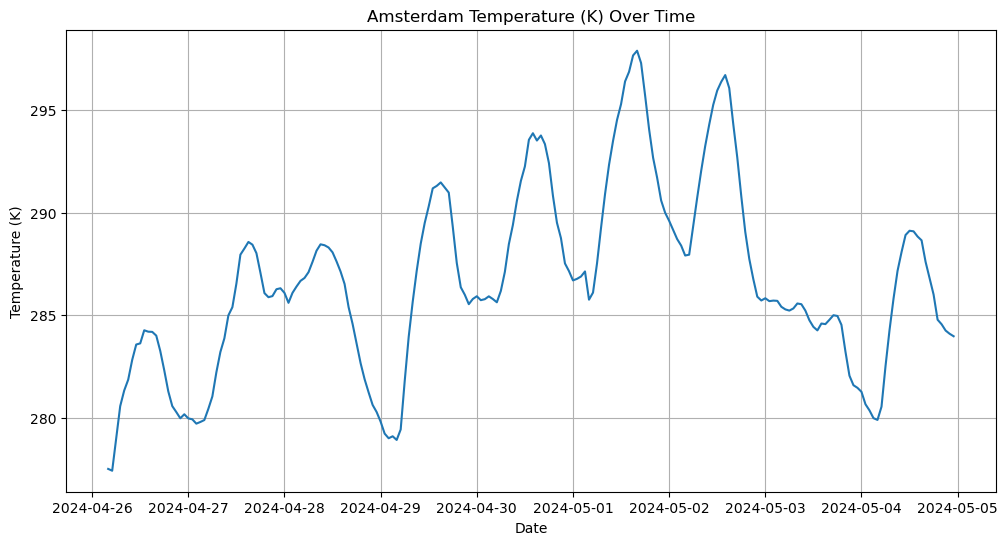

In [18]:
plt.figure(figsize = (12, 6))
plt.plot(ams_ts.index, ams_ts['t2m'])
plt.title("Amsterdam Temperature (K) Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.grid(True)

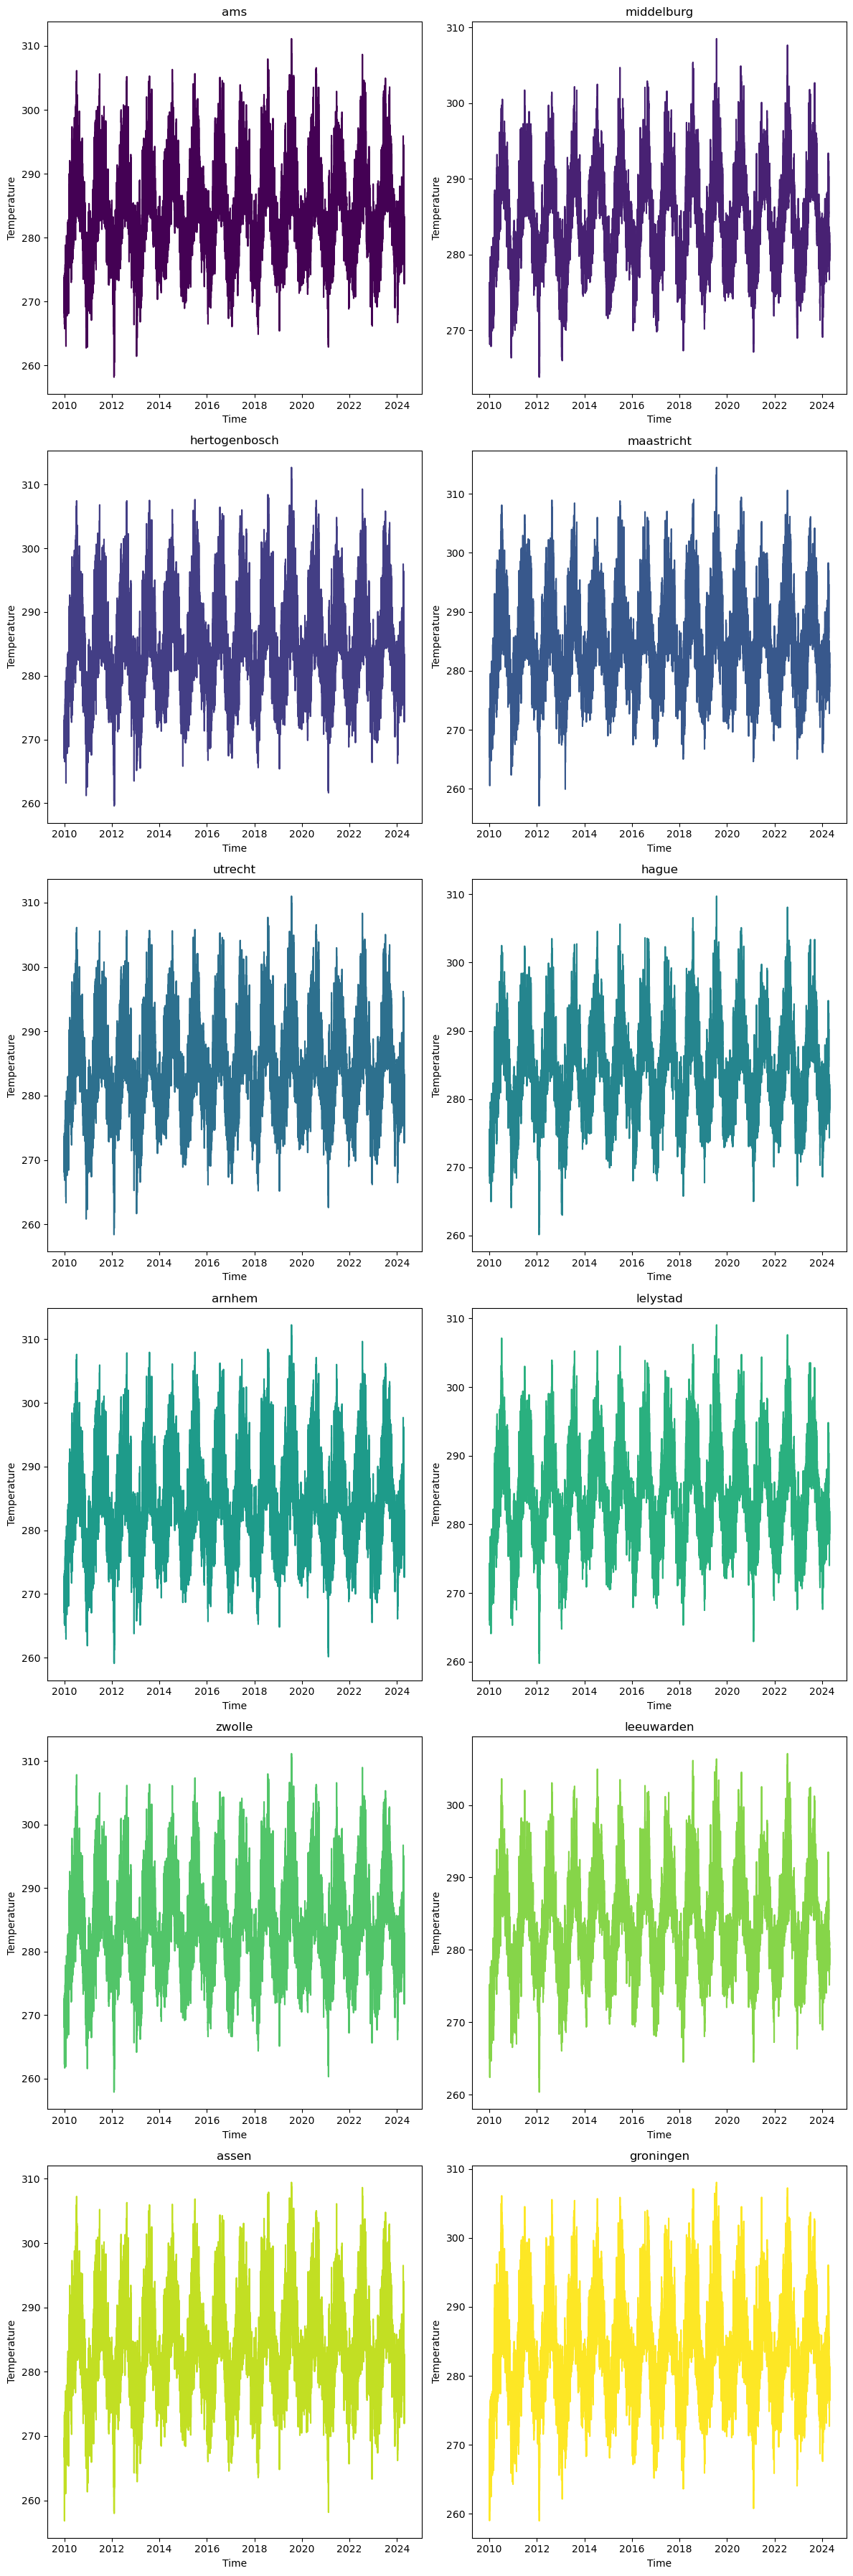

In [116]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Example: dataframes_tr = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_tr)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_tr, colors)):
    row = i // num_cols
    col = i % num_cols

    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city.index.dtype, np.datetime64):
        city.index = pd.to_datetime(city.index)

    axs[row, col].plot(city.index, city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

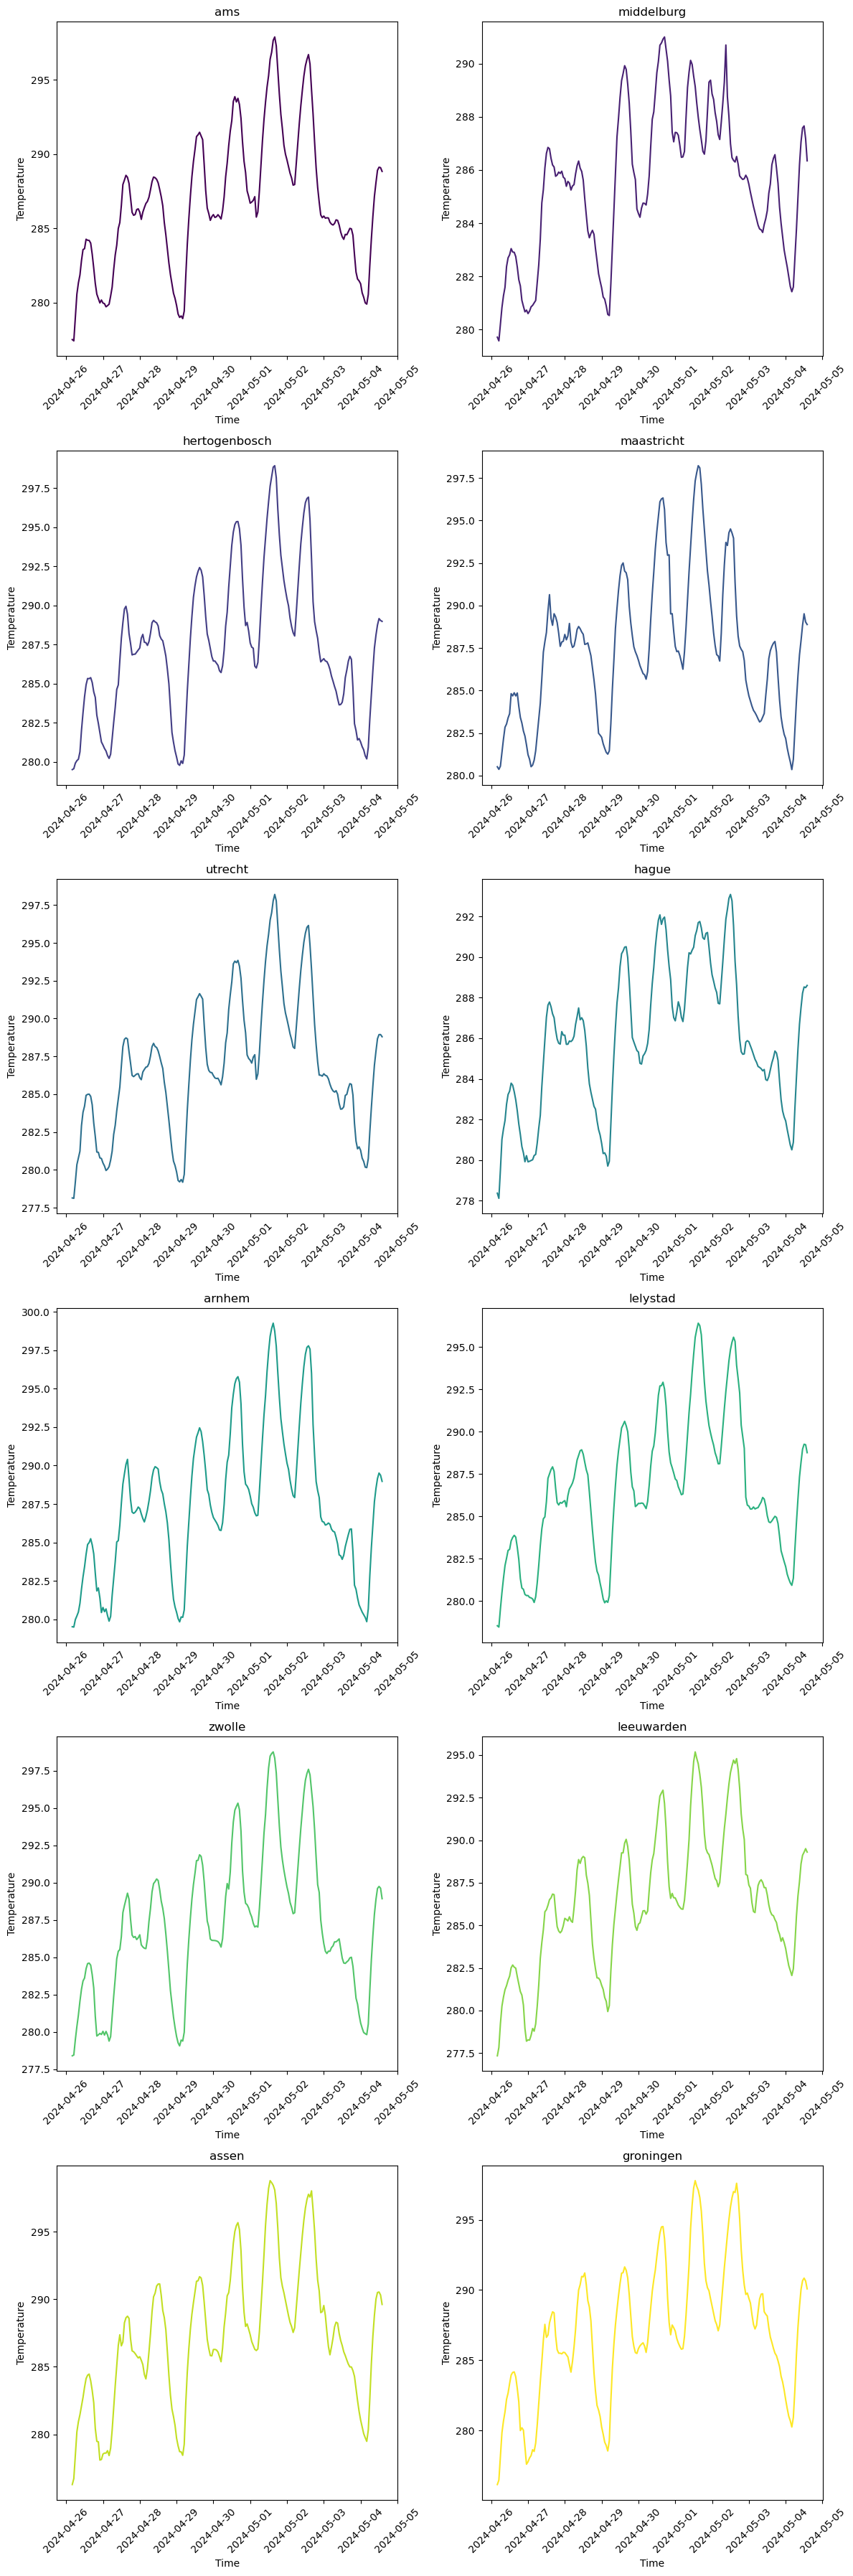

In [117]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Example: dataframes_ts = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_ts)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_ts, colors)):
    row = i // num_cols
    col = i % num_cols
    
    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city.index.dtype, np.datetime64):
        city.index = pd.to_datetime(city.index)
    
    axs[row, col].plot(city.index, city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')
    # Tilt the x-axis labels
    for tick in axs[row, col].get_xticklabels():
        tick.set_rotation(45)

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [19]:
X_test_df = {}
Y_test_df = {}

for i, city in enumerate(dataframes_ts):
    df = city.copy()

    X_test = df['t2m']
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_test = df['t2m']

    scaler = MinMaxScaler()
    X_test = X_test.values.reshape(-1, 1)
    X_test_scaled = scaler.fit_transform(X_test)
    Y_test = Y_test.values.reshape(-1, 1)
    Y_test_scaled = scaler.fit_transform(Y_test)

    X_test_tensor, Y_test_tensor = create_sequences(X_test_scaled, Y_test_scaled, timestep)

    X_test_df[df_names[i]] = X_test_tensor
    Y_test_df[df_names[i]] = Y_test_tensor

# 2 different approaches

- transfer learning

- separate models for each city

In [23]:
i = 'ams'

# Define your tensorXtrain, tensorYtrain, tensorXvalid, tensorYvalid, tensorXtest, and scaledYtest here
tensorXtrain = X_train_df[i]
tensorYtrain = Y_train_df[i]
tensorXvalid = X_valid_df[i]
tensorYvalid = Y_valid_df[i]
tensorXtest = X_test_df[i]
Y_test = ams_ts['t2m']

# Train the model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(tensorXtrain.shape[1], tensorXtrain.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(tensorXtrain, tensorYtrain, epochs=200, batch_size=32, validation_data=(tensorXvalid, tensorYvalid), callbacks=[early_stopping])

Epoch 1/200


2024-06-21 12:20:53.927645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:54.403549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:54.480113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:55.620567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:55.636085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:57.009327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:20:57.024671: I tensorflow/core/grappler/optimizers/cust

3138/3138 [==============================] - ETA: 0s - loss: 0.0029

2024-06-21 12:22:58.808528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:58.978877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:59.013226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:59.870996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:22:59.882546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:23:01.011154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 12:23:01.023018: I tensorflow/core/grappler/optimizers/cust

3138/3138 [==============================] - 141s 40ms/step - loss: 0.0029 - val_loss: 5.1670e-04
Epoch 2/200
3138/3138 [==============================] - 121s 38ms/step - loss: 3.1874e-04 - val_loss: 6.3162e-04
Epoch 3/200
3138/3138 [==============================] - 115s 37ms/step - loss: 2.8449e-04 - val_loss: 3.7642e-04
Epoch 4/200
3138/3138 [==============================] - 116s 37ms/step - loss: 2.2252e-04 - val_loss: 4.7649e-04
Epoch 5/200
3138/3138 [==============================] - 116s 37ms/step - loss: 1.6864e-04 - val_loss: 3.7057e-04
Epoch 6/200
3138/3138 [==============================] - 117s 37ms/step - loss: 1.5564e-04 - val_loss: 3.8452e-04
Epoch 7/200
3138/3138 [==============================] - 117s 37ms/step - loss: 1.5293e-04 - val_loss: 3.9678e-04
Epoch 8/200
3138/3138 [==============================] - 115s 37ms/step - loss: 1.5155e-04 - val_loss: 4.5336e-04
Epoch 9/200
3138/3138 [==============================] - 115s 37ms/step - loss: 1.4720e-04 - val_loss: 2

In [24]:
Y_test = ams_ts['t2m']

2024-06-21 13:44:26.061553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 13:44:26.266782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 13:44:26.279340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 13:44:27.200347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 13:44:27.212486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 13:44:28.408179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-21 13:44:28.419336: I tensorflow/core/grappler/optimizers/cust

7/7 [==============================] - 5s 154ms/step


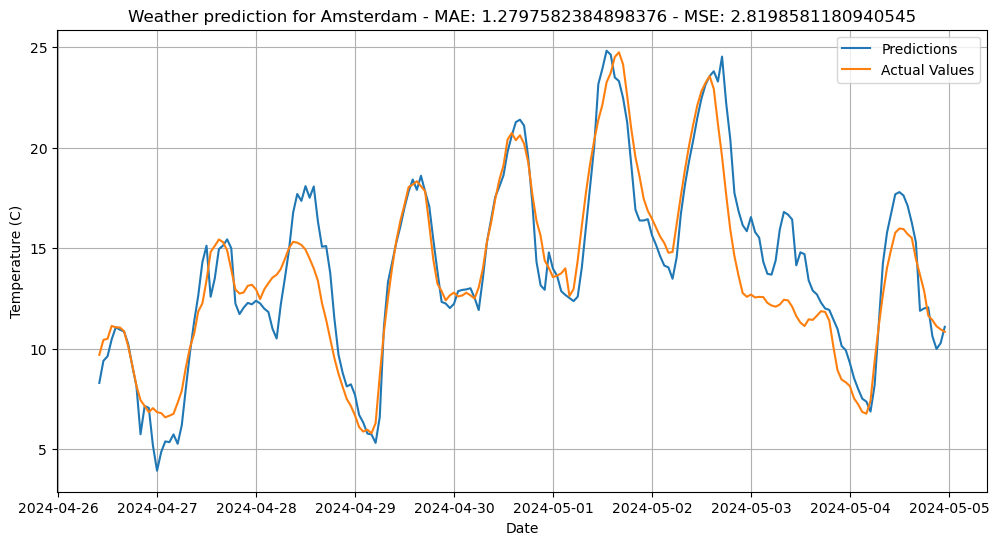

In [25]:
true_predict = scaler.inverse_transform(model.predict(X_test_tensor))

mae = mean_absolute_error(Y_test[-len(true_predict):], true_predict)
mse = mean_squared_error(Y_test[-len(true_predict):], true_predict)

plt.figure(figsize = (12, 6))
plt.plot(Y_test.index[-len(true_predict):], true_predict - 273.15, label = "Predictions")
plt.plot(Y_test[-len(true_predict):] - 273.15, label = "Actual Values")
plt.title(f"Weather prediction for Amsterdam - MAE: {mae} - MSE: {mse}")
plt.ylabel("Temperature (C)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

# SHAP

# FORECAST

In [26]:
model = load_model('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/Python/LSTM/models/ams')

KeyboardInterrupt: 

In [27]:
def multi_step_forecast(test_array, steps):
    forecast_values = []
    var_array = test_array # shift every iteration
    forecast_tensor = np.expand_dims(test_array, axis=0)  # add dim to array if single feature
    for i in range(steps):
        y_forecast = model.predict(forecast_tensor, verbose = False)
        forecast_values.append(y_forecast)
        var_array = np.concatenate((var_array[1:], y_forecast), axis = 0)
        forecast_tensor = np.expand_dims(var_array, axis = 0)
    forecast = [i[0][0] for i in forecast_values]
    return forecast

In [28]:
forecast_df = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/forecast/forecast.csv')

In [29]:
forecast_ams = forecast_df[(forecast_df['latitude'] == 52.25) & (forecast_df['longitude'] == 5.)]

forecast = multi_step_forecast(X_test_tensor[-1], 72)

forecast_df = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/forecast/forecast.csv')

forecast_df.set_index('time', inplace = True, drop = True)
forecast_ams = forecast_df[(forecast_df['latitude'] == 52.25) & (forecast_df['longitude'] == 5.)]

Y_forecast = forecast_ams['t2m'][:72].values

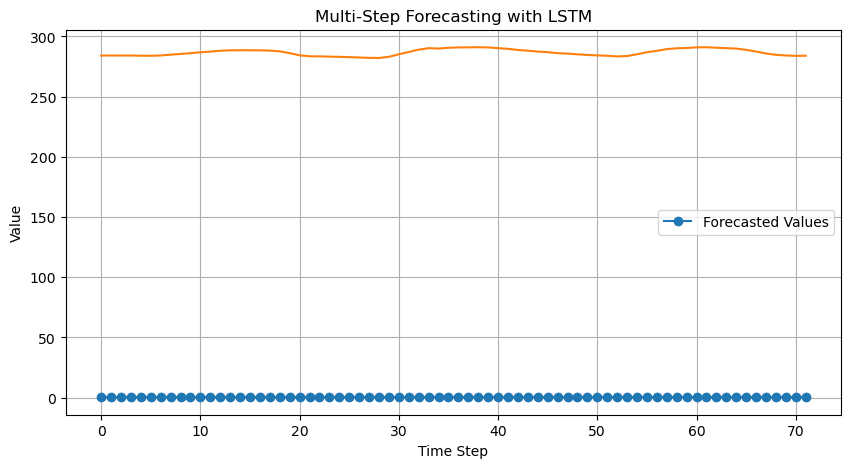

In [403]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(forecast, label='Forecasted Values', marker='o')
plt.plot(Y_forecast[:72])
plt.title('Multi-Step Forecasting with LSTM')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

In [31]:
mega = np.concatenate((Y_test.values, forecast.flatten()), axis = 0)

In [32]:
mega_real = np.concatenate((Y_test.values, Y_forecast), axis = 0)

In [1]:
plt.figure(figsize = (12, 6))
plt.plot(mega, label = "FORECAST")
# plt.plot(Y_test.values)
plt.plot(mega_real, label = "ACTUAL VALUES")
plt.grid(True)
plt.legend()
plt.ylabel("Degrees (K)")
plt.xlabel("time step")
plt.title("LSTM Forecast 72 Hours in The Future")

NameError: name 'plt' is not defined

In [314]:
test_2 = pd.read_csv('/Users/lpaggen/Documents/PROJECT 2-@/Project2-2/Project_2-2/NL_data/train_set/p1.csv')

In [315]:
test_2_ams = test_2[(test_2['latitude'] == 52.25) & (test_2['longitude'] == 5.)]

In [319]:
test_2_ams.set_index('time', inplace = True)

In [334]:
ams_ts_1 = ams_ts['t2m'].values
ams_ts_1_idx = ams_ts['valid_time'].values

In [328]:
ams_ts_2 = test_2_ams['t2m'].values
ams_ts_2_idx = test_2_ams.index.values

In [337]:
ams_ts_fixed = np.concatenate((ams_ts_1, ams_ts_2), axis = 0)
ams_ts_idx_fixed = np.concatenate((ams_ts_1_idx, ams_ts_2_idx), axis = 0)

In [338]:
ams_ts_fixed

array([277.52148, 277.4331 , 278.99365, 280.57794, 281.34003, 281.86914,
       282.83508, 283.57947, 283.63647, 284.27393, 284.2057 , 284.19592,
       284.0138 , 283.265  , 282.3192 , 281.30017, 280.57983, 280.2909 ,
       279.98694, 280.18286, 279.98145, 279.93677, 279.72614, 279.80707,
       279.9015 , 280.44788, 281.05017, 282.22412, 283.21448, 283.88196,
       284.99878, 285.39795, 286.54932, 287.95728, 288.25732, 288.57617,
       288.44458, 288.0288 , 287.07495, 286.0846 , 285.88574, 285.9392 ,
       286.27332, 286.32043, 286.0951 , 285.61133, 286.0962 , 286.4032 ,
       286.68054, 286.8214 , 287.10382, 287.60718, 288.1505 , 288.46057,
       288.4165 , 288.3058 , 288.06946, 287.62463, 287.13403, 286.5282 ,
       285.40283, 284.58167, 283.62402, 282.67053, 281.88983, 281.24792,
       280.63715, 280.29144, 279.8202 , 279.24023, 279.01465, 279.1106 ,
       278.93225, 279.4408 , 281.78772, 283.951  , 285.6587 , 287.16833,
       288.48767, 289.50342, 290.31104, 291.187  , 

In [339]:
ams_ts_idx_fixed

array(['2024-04-26 04:00:00', '2024-04-26 05:00:00',
       '2024-04-26 06:00:00', '2024-04-26 07:00:00',
       '2024-04-26 08:00:00', '2024-04-26 09:00:00',
       '2024-04-26 10:00:00', '2024-04-26 11:00:00',
       '2024-04-26 12:00:00', '2024-04-26 13:00:00',
       '2024-04-26 14:00:00', '2024-04-26 15:00:00',
       '2024-04-26 16:00:00', '2024-04-26 17:00:00',
       '2024-04-26 18:00:00', '2024-04-26 19:00:00',
       '2024-04-26 20:00:00', '2024-04-26 21:00:00',
       '2024-04-26 22:00:00', '2024-04-26 23:00:00',
       '2024-04-27 00:00:00', '2024-04-27 01:00:00',
       '2024-04-27 02:00:00', '2024-04-27 03:00:00',
       '2024-04-27 04:00:00', '2024-04-27 05:00:00',
       '2024-04-27 06:00:00', '2024-04-27 07:00:00',
       '2024-04-27 08:00:00', '2024-04-27 09:00:00',
       '2024-04-27 10:00:00', '2024-04-27 11:00:00',
       '2024-04-27 12:00:00', '2024-04-27 13:00:00',
       '2024-04-27 14:00:00', '2024-04-27 15:00:00',
       '2024-04-27 16:00:00', '2024-04-27 17:0

# LINEAR REGRESSION

In [160]:
import seaborn as sns

No frequency information was provided, so inferred frequency H will be used.
Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


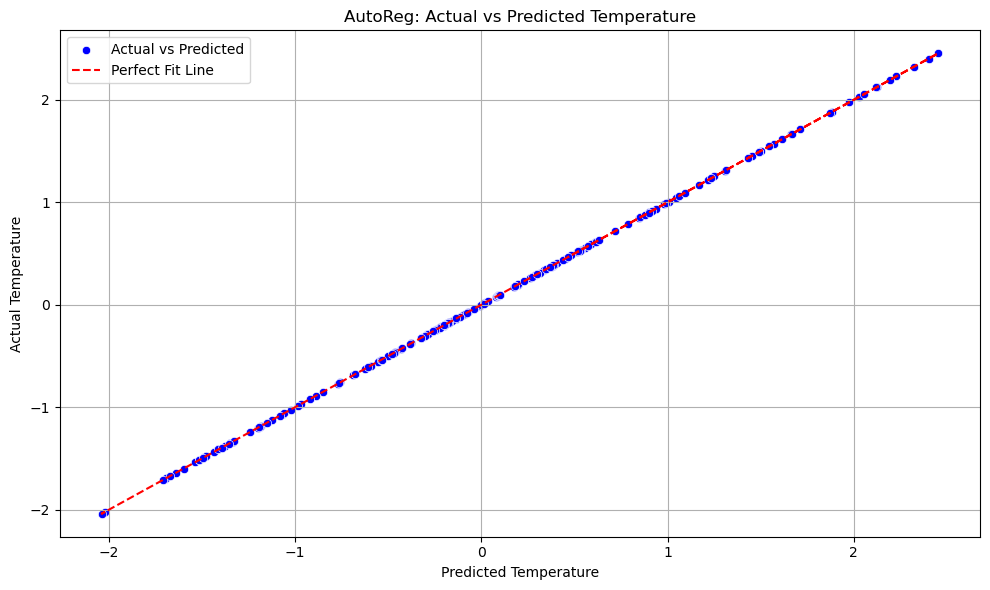

                            AutoReg Model Results                             
Dep. Variable:                    t2m   No. Observations:               125500
Model:                   AutoReg-X(7)   Log Likelihood              573696.704
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Wed, 19 Jun 2024   AIC                       -1147371.407
Time:                        14:41:23   BIC                       -1147264.267
Sample:                    01-01-2010   HQIC                      -1147339.221
                         - 04-26-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4846   4.23e+06  -8.25e-07      1.000   -8.28e+06    8.28e+06
t2m.L1     -7.668e-14   3.12e-05  -2.46e-09      1.000   -6.11e-05    6.11e-05
t2m.L2      6.699e-14   3.39e-05   1.98e-09      1.0

In [237]:
# Select predictors (X) and target (y)
x_train = ams_tr['t2m']
y_train = ams_tr['t2m']

x_test = ams_ts['t2m']
y_test = ams_ts['t2m']

# Add a constant for the intercept term
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# Fit the AutoReg model
lags = 7  # Number of lagged terms to include
model = AutoReg(y_train, lags=lags, exog=x_train, old_names=False)
fitted_model = model.fit()

# Make predictions
predictions = fitted_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog_oos=x_test)

# Plotting the actual versus predicted values
plt.figure(figsize=(10, 6))

scaler = StandardScaler()

# Scale predictions and actuals for plotting
predictions_reshape = np.array(predictions.values).reshape(-1, 1)
scaled_predictions = scaler.fit_transform(predictions_reshape).flatten()

y_test_reshape = np.array(y_test.values).reshape(-1, 1)
scaled_y_test = scaler.fit_transform(y_test_reshape).flatten()

# Plot the scatter plot of actual versus predicted values
sns.scatterplot(x=scaled_predictions, y=scaled_y_test, color='blue', label='Actual vs Predicted')

# Plot the perfect fit line (y = x)
plt.plot(scaled_y_test, scaled_y_test, color='red', linestyle='--', label='Perfect Fit Line')

plt.xlabel('Predicted Temperature')
plt.ylabel('Actual Temperature')
plt.title('AutoReg: Actual vs Predicted Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print model summary
print(fitted_model.summary())

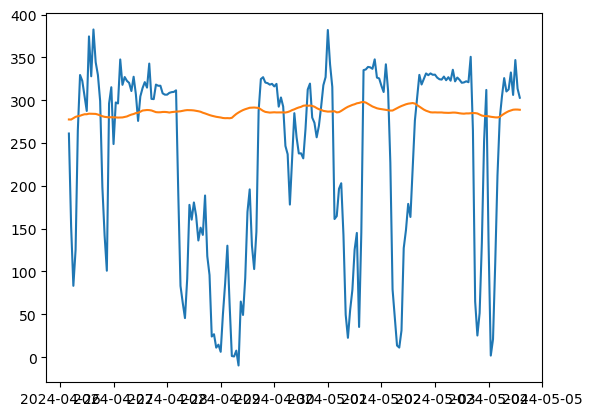

In [223]:
plt.plot(predictions)
plt.plot(y_test)

**LSTM NOTES**

-> using Adam doesn't give great results
-> using rmsprop gives better results

# ARIMA MODEL FOR FORECASTING

In [13]:
X_train = ams_tr['t2m'].values